# Marathon Data Playground

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime


/Users/brendanlai/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
df = pd.read_csv("data/activities_updated.csv")
df['Activity Date'] = pd.to_datetime(df['Activity Date'])
df = df.sort_values(by=['Activity Date'])
df['Elapsed_min'] = df['Elapsed Time'].div(60)
df['Avg_speed_kmh'] = df['Distance'].div(df['Elapsed Time'] / 3600)


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970 entries, 591 to 885
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Activity ID                970 non-null    int64         
 1   Activity Date              970 non-null    datetime64[ns]
 2   Activity Name              970 non-null    object        
 3   Activity Type              970 non-null    object        
 4   Activity Description       714 non-null    object        
 5   Elapsed Time               970 non-null    int64         
 6   Distance                   970 non-null    float64       
 7   Max Heart Rate             736 non-null    float64       
 8   Relative Effort            736 non-null    float64       
 9   Commute                    970 non-null    bool          
 10  Activity Gear              504 non-null    object        
 11  Filename                   917 non-null    object        
 12  Elapse

In [40]:
run_df = df[df['Activity Type'] == "Run"]
run_df = run_df[run_df['Avg_speed_kmh'] > 6]
def is_indoor_run(df):
    if np.isnan(df['Weather Condition']):
        return "Indoor"
    else:
        return "Outdoor"
    
run_df['Run_type'] = run_df.apply(is_indoor_run, axis=1)

(array([175.,  92.,  18.,  29., 528.,  98.,   6.,   6.,   9.,   9.]),
 array([ 0.   ,  2.604,  5.208,  7.812, 10.416, 13.02 , 15.624, 18.228,
        20.832, 23.436, 26.04 ]),
 <BarContainer object of 10 artists>)

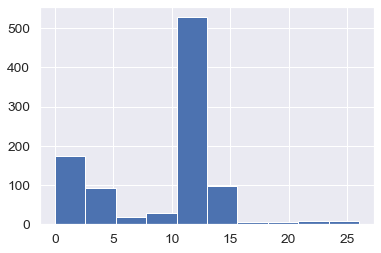

In [41]:
plt.hist(df['Avg_speed_kmh'])

In [42]:
hr_run_df = run_df[run_df['Average Heart Rate'].notna()]


In [43]:
hr_run_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 965 to 885
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Activity ID                464 non-null    int64         
 1   Activity Date              464 non-null    datetime64[ns]
 2   Activity Name              464 non-null    object        
 3   Activity Type              464 non-null    object        
 4   Activity Description       398 non-null    object        
 5   Elapsed Time               464 non-null    int64         
 6   Distance                   464 non-null    float64       
 7   Max Heart Rate             464 non-null    float64       
 8   Relative Effort            464 non-null    float64       
 9   Commute                    464 non-null    bool          
 10  Activity Gear              382 non-null    object        
 11  Filename                   464 non-null    object        
 12  Elapse

Text(0.5, 1.0, 'Relationship between Relative effort and elapsed time')

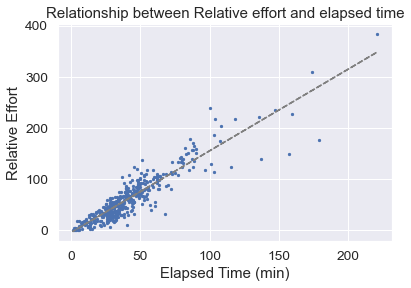

In [63]:
z = np.polyfit(hr_run_df['Elapsed_min'], hr_run_df['Relative Effort'], 1)
lin_reg = np.poly1d(z)

plt.scatter(hr_run_df['Elapsed_min'], hr_run_df['Relative Effort'], s=5)
plt.plot(hr_run_df['Elapsed_min'], lin_reg(hr_run_df['Elapsed_min']), color='grey', linestyle='dashed')
plt.xlabel("Elapsed Time (min)")
plt.ylabel("Relative Effort")
plt.title("Relationship between Relative effort and elapsed time")


In [57]:
hr_run_df['Elapsed_min']

965    29.300000
624    31.933333
203    27.500000
141     5.683333
66     38.216667
         ...    
86     40.716667
52     40.066667
18     35.316667
917    36.800000
885    55.600000
Name: Elapsed_min, Length: 464, dtype: float64

In [47]:
tmp = hr_run_df[hr_run_df['Run_type'] == "Outdoor"]
rel_eff_corr_df = tmp[['Activity Date','Average Heart Rate','Weather Temperature','Relative Effort', 'Elapsed_min','Avg_speed_kmh','Elevation Gain','Max Heart Rate','Distance']]

Text(0.5, 1.0, "Understanding what factors into Strava's relative effort metric and what it mostly correlates to")

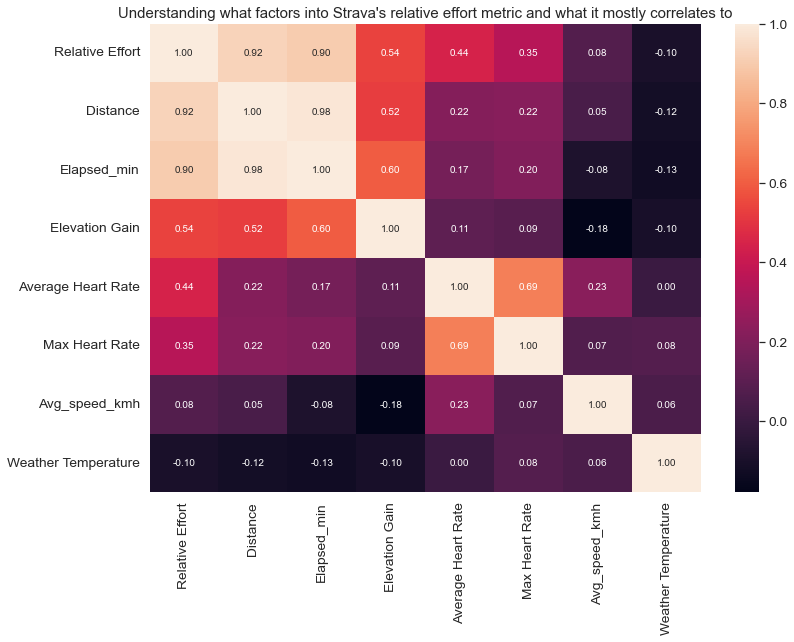

In [48]:
corr = rel_eff_corr_df.corr()
# focused heatmap - Relative Effort
# number of variables to be selected
k = len(corr.columns)

# finding the most correlated variables
cols = corr.nlargest(k, 'Relative Effort')['Relative Effort'].index
cm = np.corrcoef(rel_eff_corr_df[cols].values.T)

#plotting the heatmap
f, ax = plt.subplots(figsize=(12,9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.tight_layout()
plt.title("Understanding what factors into Strava's relative effort metric and what it mostly correlates to")

Text(0.5, 1.0, 'Weather temperature over time')

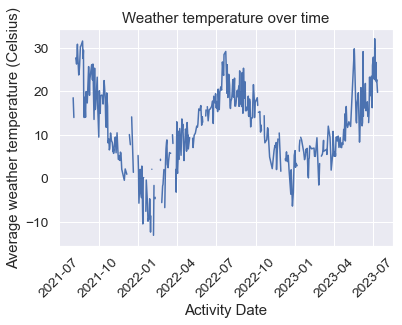

In [49]:
# Weather trend of my running life
plt.plot(hr_run_df['Activity Date'], hr_run_df['Weather Temperature'])
plt.xticks(rotation=45)
plt.ylabel("Average weather temperature (Celsius)")
plt.xlabel("Activity Date")
plt.title("Weather temperature over time")
